In [ ]:
# import all relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
import datetime


Cluster Analysis: To better understand what typical charging sessions look like, carry out a cluster
analysis to provide management with a succinct report of archetypical charging events. Think of an
appropriate trade-off between explainability and information content and try to come up with names
for these clusters. What is the value of identifying different types of charging sessions?

The different clusters seem to be fully/fast charging cars, cars on the station after done charging and cars not fully charged

Different Clustering of the Data, Starting with kmeans

Month 

Time, KWh, Month, Temperature, doneCharging true/false, 
Maybe Charging time, onStationButNotChargingTime, siteId

Data Preparations for the Clustering

In [ ]:
input_data = pd.read_csv("./charging_cleaned.csv")

# determining the total amount of seconds spent on the charging station
time_in = input_data["connectionTime"]
time_out = input_data["disconnectTime"]

time_in = pd.to_datetime(time_in)
time_out = pd.to_datetime(time_out)

#print(time_in)

time_all = time_out - time_in
#time_all.to_csv("./time_total.csv")

time_sec = np.zeros(time_all.size)

for i in range(time_all.size):
   time_sec[i] = int(time_all[i].total_seconds())


KWh = input_data["kWhDelivered"]



# time on charging station while not charging
time_w = input_data["doneChargingTime"]
time_w = pd.to_datetime(time_w)

time_wasted = time_out - time_w


# the donechargingtime is calculated and if the charging gets interrupted therefore time_donecharging > time_out 
time_wasted_sec = np.zeros(time_wasted.size)

for i in range(time_wasted.size):
   time_wasted_sec[i] = int(time_wasted[i].total_seconds())

# set all negativ due to the reason above to 0 -> no time on cable wasted
time_wasted_sec[time_wasted_sec < 0]  = 0

# time in percent that is not wasted
time_perc = (time_wasted_sec / time_sec) * 100

# time that would still need to be charged / percentage of how much the car was charged
time_ncharged = time_w - time_out  

time_sec_not_charged = np.zeros(time_ncharged.size)

for i in range(time_ncharged.size):
   time_sec_not_charged[i] = int(time_ncharged[i].total_seconds())

time_sec_not_charged[time_sec_not_charged < 0]  = 0

perc_charged = (time_sec / (time_sec_not_charged + time_sec)) * 100 

# registered user
reg_user = input_data["userID"]
reg_user[reg_user != 0] = 1 

#print(time_perc)

# preparing the months just using the connectiontime
month = time_in.dt.month 

#print(month)


# preparing the days just using the connectiontime
days = time_in.dt.day 

# preparing the siteId
site_Id = input_data["siteID"]

# preparing the datamatches from input and overall?
matches = input_data["date_matches"]

# time of the day
time_of_day = time_in.dt.hour 
print(time_of_day)

# time that would still be needed to finish charging
time_left  =  input_data["doneChargingTime"]
time_left = pd.to_datetime(time_left)
time_left = time_left - time_out

time_left_sec = np.zeros(time_left.size)

for i in range(time_left.size):
   time_left_sec[i] = int(time_left[i].total_seconds())

# set all negativ due to the reason above to 0 -> no time on cable wasted
time_left_sec[time_left_sec < 0]  = 0


# All of the data from the user inputs, to see if there is a difference, userInputs_WhPerMile, userInputs_kWhRequested, userInputs_milesRequested, userInputs_minutesAvailable, userInputs_modifiedAt, userInputs_paymentRequired,  userInputs_requestedDeparture
# determining the total amount of seconds spent on the charging station
time_all_user = input_data["userInputs_minutesAvailable"]

KWh_user = input_data["userInputs_kWhRequested"]

# userInputs_WhPerMile
Wh_per_mile_user = input_data["userInputs_WhPerMile"]

# userInputs_milesRequested 
miles_req = input_data["userInputs_milesRequested"]

# userInputs_modifiedAt
mod_at = input_data["userInputs_modifiedAt"]

# userInputs_paymentRequired
pay_req = input_data["userInputs_paymentRequired"]

# userInputs_requestedDeparture
req_dep = input_data["userInputs_requestedDeparture"]




C:\Users\bkran\AppData\Local\Temp\ipykernel_40480\3613127506.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_user[reg_user != 0] = 1


0        13
1        13
2        13
3        13
4        14
         ..
66445    18
66446    18
66447    19
66448    19
66449    19
Name: connectionTime, Length: 66450, dtype: int32


K-Means Clustering

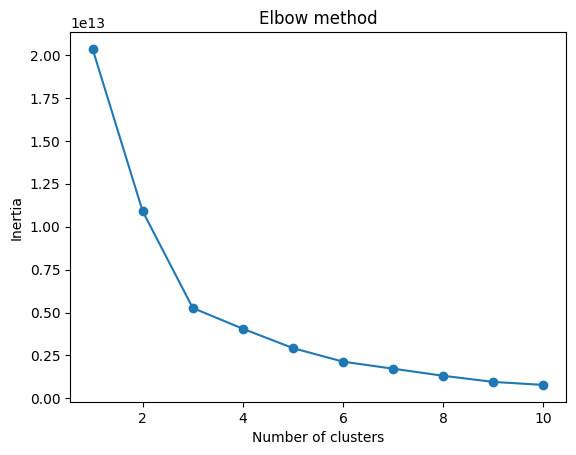

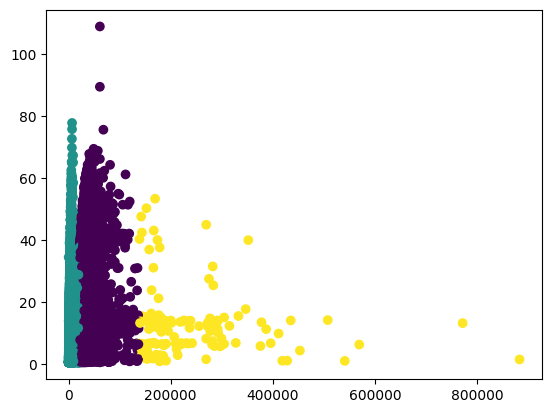

In [ ]:
data = list(zip(time_sec, KWh))
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 

kmeans = KMeans(n_clusters=3)
kmeans.fit(data)
inertias.append(kmeans.inertia_)

plt.scatter(time_sec, KWh, c=kmeans.labels_, xlabel="Energy in kHw", ylabel="Time on Station in Seconds")
plt.show() 

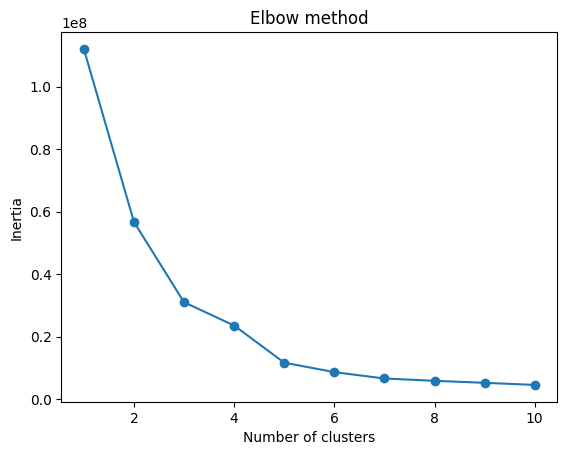

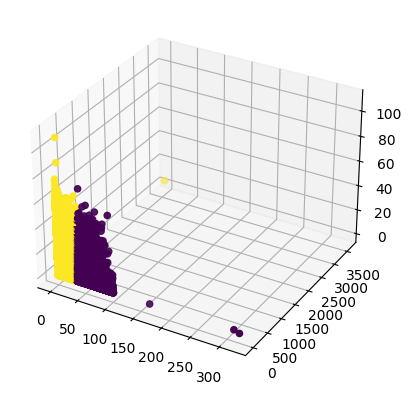

In [ ]:
# Clustering including the energy and if it was fully charged or not
data = list(zip(KWh, time_perc, perc_charged))
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)
inertias.append(kmeans.inertia_)

ax = plt.axes(projection='3d')

# time_perc is the time used in percent
ax.scatter3D(KWh, time_perc, time_perc,c=kmeans.labels_)


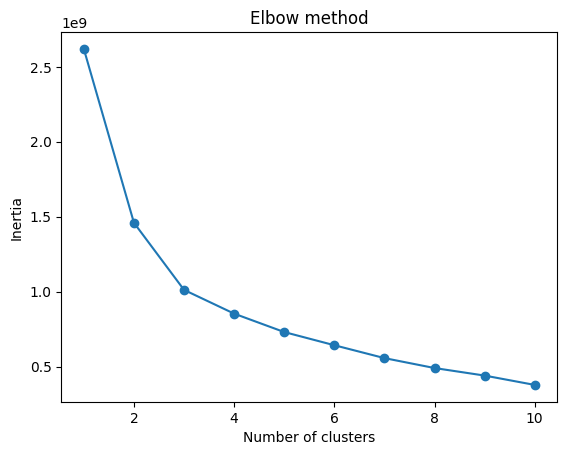

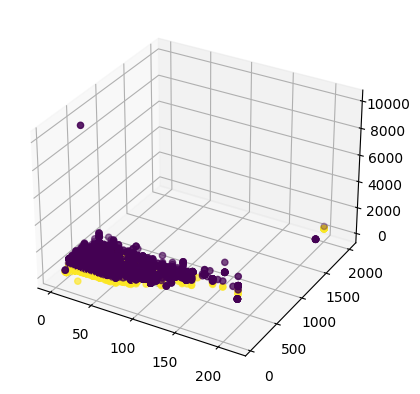

In [ ]:
# Clustering of the user defined data to see if the same phenomenome happens as with the official data with the same 2 datapoints, time and energy
data = list(zip(time_all_user, kWh_user))
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 

kmeans = KMeans(n_clusters=3)
kmeans.fit(data)
inertias.append(kmeans.inertia_)

plt.scatter(time_all_user, kWh_user, c=kmeans.labels_)
plt.show() 

In [ ]:
# data from the user as a 3d plot same as the second plot
data = list(zip(KWh, time_perc, perc_charged))
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 

kmeans = KMeans(n_clusters=2)
kmeans.fit(data)
inertias.append(kmeans.inertia_)

ax = plt.axes(projection='3d')

# time_perc is the time used in percent
ax.scatter3D(KWh, time_perc, time_perc,c=kmeans.labels_)


Clustering of the weather in combination with the data

In [ ]:
# data of weather from the merging file 
weather = pd.read_csv("../Tasks/weather_cleaned.csv", encoding="ISO-8859-1")
charging = pd.read_csv("../Tasks/charging_cleaned.csv", encoding="ISO-8859-1")

charging['connectionTime'] = pd.to_datetime(charging['connectionTime'], utc=True)
weather['timestamp'] = pd.to_datetime(weather['timestamp'], utc=True)

charging['hour'] = charging['connectionTime'].dt.floor('h')

weather['hour'] = weather['timestamp'].dt.floor('h')

merged_data = pd.merge(
    charging,
    weather[['hour', 'temperature']], 
    on='hour', 
    how='inner'
)

In [ ]:
# Preparing data for CLustering 
temp = merged_data["temperature"]

time_in_w = merged_data["connectionTime"]
time_out_w = merged_data["disconnectTime"]

time_in_w = pd.to_datetime(time_in_w)
time_out_w = pd.to_datetime(time_out_w)

time_all_w = time_out_w - time_in_w

time_sec_weather = np.zeros(time_all_w.size)

for i in range(time_all_w.size):
   time_sec_weather[i] = int(time_all_w[i].total_seconds())


# energy weather
kHw_w = merged_data["kWhDelivered"]



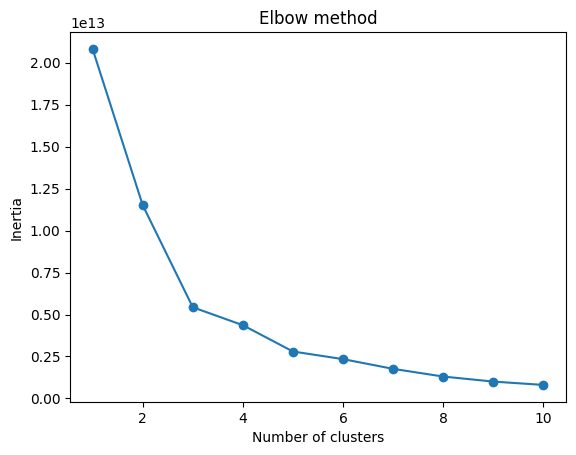

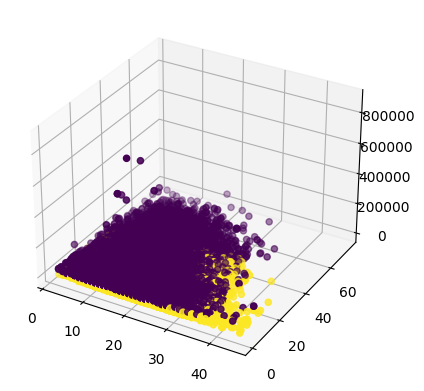

In [ ]:
# Kmeans with weather
data = list(zip(temp, kHw_w, time_sec_weather))
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 

kmeans = KMeans(n_clusters=3)
kmeans.fit(data)
inertias.append(kmeans.inertia_)

ax = plt.axes(projection='3d')
ax.scatter3D(kHw_w, time_sec_weather, temp, c=kmeans.labels_)